In [ ]:
!pip install lmdb joblib tqdm opencv-python gdown faiss-cpu Pillow

     |████████████████████████████████| 8.6 MB 4.6 MB/s 


In [ ]:
!gdown --id 15OA8TMkAsEQ2fa0dCv59-mdGGBSE-KIJ

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15OA8TMkAsEQ2fa0dCv59-mdGGBSE-KIJ
To: /content/archive_scenery.zip
100% 650M/650M [00:04<00:00, 145MB/s]


In [ ]:
%%time
import zipfile
zip_ref = zipfile.ZipFile("archive_scenery.zip", 'r')
zip_ref.extractall("./scenery")
zip_ref.close()

CPU times: user 4 s, sys: 1.42 s, total: 5.42 s
Wall time: 6.18 s


convert filenames to sequential ids

In [ ]:
import os
n = 1
FILE_PATH="./scenery/"
from tqdm import tqdm
file_names = os.listdir(FILE_PATH)
file_names.sort()
for file_name in tqdm(file_names):
    oldext = os.path.splitext(file_name)[1]
    os.rename(FILE_PATH+file_name, FILE_PATH + str(n) + oldext)
    n += 1

100%|██████████| 4319/4319 [00:00<00:00, 16851.27it/s]


calculate rgb histograms, store in lmdb

In [ ]:
import cv2
import numpy as np
from os import listdir
from joblib import Parallel, delayed
from tqdm import tqdm
import lmdb

def int_to_bytes(x: int) -> bytes:
    return x.to_bytes((x.bit_length() + 7) // 8, 'big')

DB = lmdb.open('./rgb_histograms.lmdb',map_size=500*1_000_000) #500mb
IMAGE_PATH = "./scenery"


def check_if_exists_by_id(id):
    with DB.begin(buffers=True) as txn:
        x = txn.get(int_to_bytes(id),default=False)
        if x:
            return True
        return False

def get_features(query_image):
    query_hist_combined = cv2.calcHist([query_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    query_hist_combined = query_hist_combined.flatten()
    query_hist_combined = query_hist_combined*10000000
    query_hist_combined = np.divide(query_hist_combined, query_image.shape[0]*query_image.shape[1], dtype=np.float32)
    return query_hist_combined

def calc_hists(file_name):
    file_id = int(file_name[:file_name.index('.')])
    img_path = IMAGE_PATH+"/"+file_name
    query_image = cv2.imread(img_path)
    if query_image is None:
        print(f'error reading {img_path}')
        return None
    if query_image.shape[2] == 1:
        query_image = cv2.cvtColor(query_image, cv2.COLOR_GRAY2RGB)
    else:
        query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    image_features = get_features(query_image)
    return (int_to_bytes(file_id), image_features.tobytes())


file_names = listdir(IMAGE_PATH)
file_names.sort()
print(f"images in {IMAGE_PATH} = {len(file_names)}")
new_images = []

for file_name in tqdm(file_names):
    file_id = int(file_name[:file_name.index('.')])
    if check_if_exists_by_id(file_id):
        continue
    new_images.append(file_name)

print(f"new images = {len(new_images)}")
new_images = [new_images[i:i + 100000] for i in range(0, len(new_images), 100000)]
for batch in new_images:
    rgb_hists = Parallel(n_jobs=-1, verbose=1)(delayed(calc_hists)(file_name) for file_name in batch)
    rgb_hists = [i for i in rgb_hists if i]  # remove None's
    print("pushing data to db")
    with DB.begin(write=True, buffers=True) as txn:
        with txn.cursor() as curs:
            curs.putmulti(rgb_hists)

images in ./scenery = 4319


100%|██████████| 4319/4319 [00:00<00:00, 130805.10it/s]

new images = 4319



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 746 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 2746 tasks      | elapsed:   44.0s


pushing data to db


[Parallel(n_jobs=-1)]: Done 4319 out of 4319 | elapsed:  1.1min finished


add to faiss index

In [ ]:
from tqdm import tqdm
import numpy as np
import lmdb
import faiss
DB_features = lmdb.open("rgb_histograms.lmdb", readonly=True)
dim = 512
faiss_dim = dim
quantizer = faiss.IndexFlat(faiss_dim, faiss.METRIC_L1)
index = faiss.IndexIDMap2(quantizer)

def int_from_bytes(xbytes: bytes) -> int:
    return int.from_bytes(xbytes, 'big')

def get_all_data_iterator(batch_size=10000):
    with DB_features.begin(buffers=True) as txn:
        with txn.cursor() as curs:
            temp_ids = np.zeros(batch_size,np.int64)
            temp_features = np.zeros((batch_size,dim),np.float32)
            retrieved = 0
            for data in curs.iternext(keys=True, values=True):
                temp_ids[retrieved] = int_from_bytes(data[0])
                temp_features[retrieved] = np.frombuffer(data[1],dtype=np.float32)
                retrieved+=1
                if retrieved == batch_size:
                    retrieved=0
                    yield temp_ids, temp_features
            if retrieved != 0:
                yield temp_ids[:retrieved], temp_features[:retrieved]

for ids, features in tqdm(get_all_data_iterator(100000)):
    index.add_with_ids(features,ids)
faiss.write_index(index,"populated.index")

1it [00:00,  6.57it/s]


Search

In [ ]:
query_image = cv2.imread(IMAGE_PATH+"/198.jpg")
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
query_hist = get_features(query_image)

In [ ]:
index = faiss.read_index("./populated.index")
D, I = index.search(query_hist.reshape(1,-1), 15)
# lims, D, I = index.range_search(query_phash.reshape(1,-1), 10000000)

In [ ]:
print("distances")
print(D)
print("indexes")
print(I)

distances
[[       0.        0.        0.  9162620.  9162620.  9670765.  9900476.
  10106291. 10335363. 10402809. 10491832. 10700423. 10762882. 10773898.
  10789610.]]
indexes
[[ 263  198  293   29   21 1973  856 1268 1592 1486 3250  862  135  665
   326]]


In [ ]:
from PIL import Image
images_np=[]
for image_id in I[0]:
  images_np.append(np.array(Image.open(f'{IMAGE_PATH}/{image_id}.jpg')))

# for image_id in I:
#   images_np.append(np.array(Image.open(f'{IMAGE_PATH}/{image_id}.jpg')))

In [ ]:
import matplotlib.pyplot as plt
def show_images(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image)

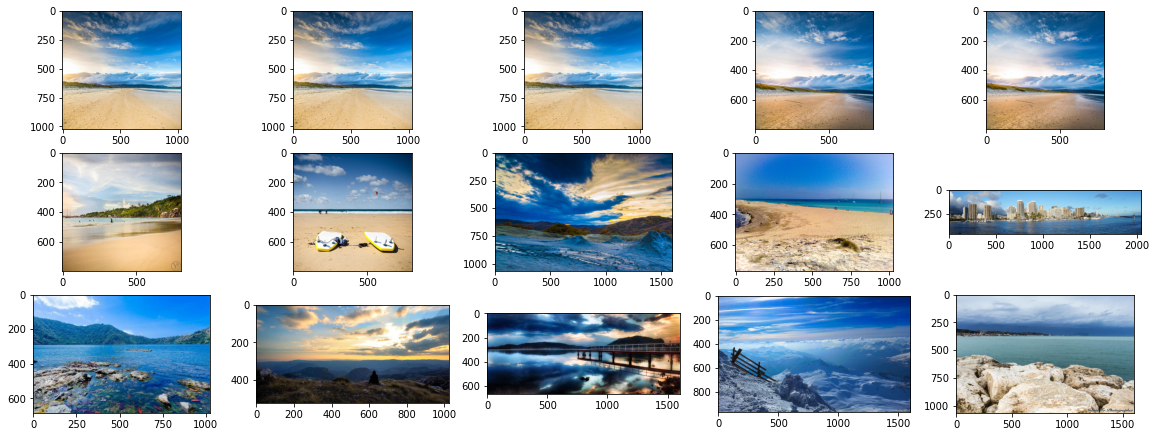

In [ ]:
show_images(images_np)